# **Installs**

In [5]:
!pip install pydot --quiet
!pip install gensim --quiet
!pip install tensorflow-datasets --quiet
!pip install -U tensorflow-text --quiet
!pip install transformers --quiet
!pip install numba

## **Imports**

In [6]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

from tqdm import tqdm
import pandas as  pd
from transformers import (
    BertTokenizer,
    BertModel,
    TFBertModel,
    BertConfig,
    AutoTokenizer,
    AutoModel,
)

from transformers import AdamW, get_linear_schedule_with_warmup
import numpy as np
from sklearn.metrics import classification_report
from sklearn import metrics
from numba import cuda

In [7]:
tf.config.run_functions_eagerly(True)

# **Data Load**

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
RECCON_PATH = '/content/drive/MyDrive/w266_final_project/data/RECCON'

In [10]:
reccon_train_preprocessed = pd.read_csv(f'{RECCON_PATH}/reccon_f1_train_preprocessed.csv')
reccon_valid_preprocessed = pd.read_csv(f'{RECCON_PATH}/reccon_f1_valid_preprocessed.csv')
reccon_test_preprocessed = pd.read_csv(f'{RECCON_PATH}/reccon_f1_test_preprocessed.csv')

In [11]:
cause_model_name = 'mrm8488/spanbert-finetuned-squadv2'

spanbert_tokenizer = BertTokenizer.from_pretrained(cause_model_name)
spanbert_model = TFBertModel.from_pretrained(cause_model_name, output_hidden_states = True)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['qa_outputs.weight', 'qa_outputs.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [12]:
reccon_train_preprocessed.head()

,Unnamed: 0,id,emotion,utterance,cause_utterance,cause_span,input_text,start_index,end_index,emotion_label
0,0,dailydialog_tr_1097_utt_1_true_cause_utt_1_span_0,happiness,Our company's wei-ya is tomorrow night ! It's ...,Our company's wei-ya is tomorrow night ! It's ...,Our company's wei-ya is tomorrow night ! It's ...,Our company's wei-ya is tomorrow night ! It's ...,30,51,3
1,1,dailydialog_tr_1097_utt_3_true_cause_utt_3_span_0,happiness,You have no idea ! There's a banquet with priz...,You have no idea ! There's a banquet with priz...,"There's a banquet with prizes , performances",You have no idea ! There's a banquet with priz...,27,35,3
2,2,dailydialog_tr_1097_utt_4_true_cause_utt_3_span_0,surprise,Really ? What kind of prizes ?,You have no idea ! There's a banquet with priz...,"There's a banquet with prizes , performances",Really ? What kind of prizes ? You have no ide...,13,21,5
3,3,dailydialog_tr_1097_utt_5_true_cause_utt_5_span_0,happiness,"Well , I heard that last year Vivian from acco...","Well , I heard that last year Vivian from acco...",last year Vivian from accounting won a new car !,"Well , I heard that last year Vivian from acco...",21,30,3
4,4,dailydialog_tr_1097_utt_6_true_cause_utt_5_span_0,surprise,A new car ! You're kidding !,"Well , I heard that last year Vivian from acco...",last year Vivian from accounting won a new car !,"A new car ! You're kidding ! Well , I heard th...",15,24,5


In [16]:
reccon_train_preprocessed = reccon_train_preprocessed[reccon_train_preprocessed.end_index < 100]

In [17]:
target_names = list(np.unique(reccon_train_preprocessed[['emotion_label', 'emotion']].sort_values(['emotion_label'])['emotion']))
target_names

['anger', 'disgust', 'fear', 'happiness', 'sadness', 'surprise']

In [18]:
MAX_SEQUENCE_LENGTH = 124 # Using 124 for max sequence length in our data.
beam_size = 4 # Beam size for predicting end index given start index for emotion cause spans

In [19]:
# Our experiments involve AUGMENTING / APPENDING on our TRAINING DATA.
# Define a function to process and tokenize training data for re-use throughout experiments.
def process_train_data(df):

  ec_train_texts = list(df.input_text)
  ec_train_e_labels = np.array(df.emotion_label)
  ec_train_si_labels = np.array(df.start_index)
  ec_train_ei_labels = np.array(df.end_index)
  ec_train_encodings = spanbert_tokenizer(ec_train_texts, truncation=True, padding='max_length', max_length=MAX_SEQUENCE_LENGTH, return_tensors='tf')

  return ec_train_texts, ec_train_e_labels, ec_train_si_labels, ec_train_ei_labels, ec_train_encodings

In [21]:
ec_valid_texts = list(reccon_valid_preprocessed.input_text)
ec_test_texts = list(reccon_test_preprocessed.input_text)

ec_valid_e_labels = np.array(reccon_valid_preprocessed.emotion_label)
ec_test_e_labels = np.array(reccon_test_preprocessed.emotion_label)

ec_valid_si_labels = np.array(reccon_valid_preprocessed.start_index)
ec_test_si_labels = np.array(reccon_test_preprocessed.start_index)

ec_valid_ei_labels = np.array(reccon_valid_preprocessed.end_index)
ec_test_ei_labels = np.array(reccon_test_preprocessed.end_index)

In [22]:
ec_valid_encodings = spanbert_tokenizer(ec_valid_texts, truncation=True, padding='max_length', max_length=MAX_SEQUENCE_LENGTH, return_tensors='tf')
ec_test_encodings = spanbert_tokenizer(ec_test_texts, truncation=True, padding='max_length', max_length=MAX_SEQUENCE_LENGTH, return_tensors='tf')

# **Scratch Work - to design the model**

In [ ]:
# @title
spanbert_out = spanbert_model([ec_valid_encodings.input_ids, ec_valid_encodings.token_type_ids, ec_valid_encodings.attention_mask])

NameError: ignored

In [ ]:
# @title
out = np.array(spanbert_out[2])

In [ ]:
# @title
# FOR EMOTION CLASSIFICATION: AVERAGE out ALL hidden states. The average SHOULD be the SAME size as the attention vector.
o = tf.stack(
    tuple(out[-i - 1] for i in range(12)), axis=1)
print(o.shape)
o

(12, 12, 124, 768)


<tf.Tensor: shape=(12, 12, 124, 768), dtype=float32, numpy=
array([[[[-0.12149484, -0.19294368, -0.1879348 , ..., -0.11795254,
          -0.11509802,  0.19834341],
         [-0.05254162, -0.17423852, -0.19125736, ..., -0.11225103,
          -0.12786518,  0.22386615],
         [-0.05584331, -0.16275132, -0.19315693, ..., -0.10716303,
          -0.12371977,  0.22144574],
         ...,
         [-0.02064001, -0.2057844 , -0.18367349, ..., -0.14269438,
          -0.13874489,  0.23958394],
         [-0.02371099, -0.20563737, -0.1836034 , ..., -0.14366648,
          -0.1374694 ,  0.2381201 ],
         [-0.03111994, -0.20308977, -0.18472582, ..., -0.13800286,
          -0.13609931,  0.2353111 ]],

        [[-0.11788816,  0.02051882, -0.09626473, ...,  0.2125257 ,
           0.29256135, -0.18052377],
         [-0.12209865,  0.22518602, -0.10208389, ...,  0.17795436,
           0.273975  , -0.22681662],
         [-0.13098134,  0.251634  , -0.11215764, ...,  0.19249701,
           0.29300457, -0

In [ ]:
# @title
mn = tf.math.reduce_mean(o, axis = 1)
mn

<tf.Tensor: shape=(12, 124, 768), dtype=float32, numpy=
array([[[-0.11873361,  0.00962868, -0.07081679, ..., -0.0113312 ,
         -0.06088461,  0.15646839],
        [-0.10059383,  0.09212306, -0.1117653 , ...,  0.1148148 ,
         -0.13936608,  0.17987907],
        [-0.2567078 ,  0.19391023, -0.02039279, ...,  0.12328783,
          0.01258335,  0.0447364 ],
        ...,
        [-0.07562445,  0.07250457, -0.09576301, ..., -0.02936693,
         -0.09037619,  0.09831848],
        [-0.08065974,  0.06743708, -0.09433597, ..., -0.02164375,
         -0.07306152,  0.08417946],
        [-0.07180012,  0.06522585, -0.09692509, ..., -0.02991987,
         -0.05663504,  0.10267846]],

       [[-0.1091171 ,  0.0390369 , -0.07514993, ..., -0.0207424 ,
         -0.01502507,  0.12430739],
        [ 0.01028993,  0.10161189, -0.19358397, ...,  0.14858182,
         -0.1139246 ,  0.11041389],
        [-0.08443069,  0.2178551 , -0.16224341, ...,  0.14177339,
          0.06573663,  0.00821751],
        ...

In [ ]:
# @title
mn_cls = mn[:,0,:]

In [ ]:
# @title
tf.keras.layers.Dense(5, activation='softmax', name='e_classification_layer')(mn_cls)

<tf.Tensor: shape=(12, 5), dtype=float32, numpy=
array([[0.24056952, 0.19019958, 0.18393365, 0.19941856, 0.18587875],
       [0.23600127, 0.18836828, 0.18620141, 0.20386747, 0.18556166],
       [0.26492658, 0.20596936, 0.16793911, 0.20268261, 0.15848234],
       [0.19479358, 0.15805496, 0.1957515 , 0.22505644, 0.22634347],
       [0.19342913, 0.16162473, 0.18945077, 0.22502169, 0.2304737 ],
       [0.24447016, 0.1876766 , 0.18198489, 0.19882983, 0.18703856],
       [0.20640226, 0.16431913, 0.1908429 , 0.22044714, 0.21798854],
       [0.27096024, 0.22194721, 0.15969908, 0.20103309, 0.14636038],
       [0.23624656, 0.18582928, 0.18728746, 0.20306848, 0.18756816],
       [0.23618276, 0.19227433, 0.1828981 , 0.20006417, 0.1885807 ],
       [0.22110316, 0.16871497, 0.18811767, 0.21922   , 0.20284428],
       [0.27336016, 0.23606609, 0.15964621, 0.18896781, 0.14195973]],
      dtype=float32)>

In [ ]:
# @title
s = [tf.keras.layers.Dense(1)(tf.keras.layers.Dropout(0.3)(mn))
     for _ in range(5)]
rm = tf.math.reduce_mean(s, axis=0)
sq = tf.squeeze(rm, axis=-1)
sft = tf.keras.layers.Softmax()(sq)
sft

In [ ]:
# @title
# Preprocessing NOTE: Start positions must be IN LINE with BERT tokenization!
start_positions = tf.keras.layers.Input(shape=(1,), dtype=tf.int64)

In [ ]:
# @title
idx = tf.keras.layers.Identity()(np.array([[2], [11]]))
idx

In [ ]:
# @title
mn

In [ ]:
# @title
st = tf.gather(mn, idx, axis = 1, batch_dims = 1)
rpt = tf.repeat(st, repeats = 12, axis = 1)
ct = tf.concat([mn, rpt], axis = -1)
lnct = tf.keras.layers.Dense(768, activation = 'tanh')(ct)
s2 = [tf.keras.layers.Dense(1)(tf.keras.layers.Dropout(0.3)(lnct))
     for _ in range(5)]
rm2 = tf.reduce_mean(s2, axis=0)
sq2 = tf.squeeze(rm2, axis=-1)
sft2 = tf.keras.layers.Softmax()(sq2)
sft2

# **Model Construction**

In [23]:
# Suppress missing gradients warnings
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

In [24]:
# Replicate Bhat and Modi's CSE model - TRAINING.
def create_ece_model(max_sequence_length=MAX_SEQUENCE_LENGTH,
                     num_train_layers=12,
                     dropout=0.3,
                     num_classes=15,
                     learning_rate=0.00005,
                     msd_samples=5):

    # Inputs
    input_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='attention_mask_layer')
    start_positions = tf.keras.layers.Input(shape=(1,), dtype=tf.int64, name='start_positions_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}

    # SpanBERT transformer

    if num_train_layers == 0:
        # Freeze all layers of pre-trained BERT model
        spanbert_model.trainable = False

    elif num_train_layers == 12:
        # Train all layers of the BERT model
        spanbert_model.trainable = True

    else:
        # Restrict training to the num_train_layers outer transformer layers
        retrain_layers = []

        for retrain_layer_number in range(num_train_layers):

            layer_code = '_' + str(11 - retrain_layer_number)
            retrain_layers.append(layer_code)

        print('retrain layers: ', retrain_layers)

        for w in spanbert_model.weights:
            if not any([x in w.name for x in retrain_layers]):
                #print('freezing: ', w)
                w._trainable = False

    bert_out = spanbert_model(bert_inputs)

    # ------EMOTION CLASSIFICATION STEP------

    # Mean Pool all hidden states and extract the CLS tokens
    hidden_states = bert_out[2]

    stacked_states = tf.stack(tuple(hidden_states[-i - 1] for i in range(12)), axis=1)

    meanpooled_states = tf.math.reduce_mean(stacked_states, axis = 1)

    meanpooled_cls_tokens = meanpooled_states[:,0,:]

    # Emotion Classification: Linear Classification Layer
    e_classification = tf.keras.layers.Dense(num_classes, activation='softmax', name='e_classification_layer')(meanpooled_cls_tokens)

    # ------CAUSE CLASSIFICATION STEP------

    # We apply a dense layer of output size 1 to the embedding vectors of size 768 for each token. This gives a scalar representation of each token.
    # Multisample dropout applies different dropout masks across copies of the size 768 input layer and then mean pools the results back together.
    start_logits = tf.squeeze(tf.reduce_mean([
                                             tf.keras.layers.Dense(1)(tf.keras.layers.Dropout(dropout)(meanpooled_states))
                                             for _ in range(msd_samples)], axis=0),
                              axis=-1)

    # Extract probabilities of starting index by softmaxing logits calculated from multisample dropout.
    start_probs = tf.keras.layers.Softmax()(start_logits)

    # In training, start positions are GIVEN. We still output the predicted start positions with the multi-sample dropout above and train,
    # but here we use the given start positions to predict the end positions and then train on end position predictions.

    # Grab the embeddings of the token of the start indices. Repeat them for the entire input length.
    embedding_start_indices = tf.gather(meanpooled_states, start_positions, axis = 1, batch_dims = 1)
    repeated_start_embeds = tf.repeat(embedding_start_indices, repeats = max_sequence_length, axis = 1)

    # Concatenate the start embeddings with the mean pooled states.
    concat_embeds = tf.concat([meanpooled_states, repeated_start_embeds], axis = -1)

    # Apply a linear layer with tanh activation back to an output size of 768 - the original BERT embedding dimension.
    linear_layer = tf.keras.layers.Dense(768, activation = 'tanh')(concat_embeds)

    # Apply the same multisample dropout method for the 768-vectors to get end logits.
    end_logits = tf.squeeze(tf.reduce_mean([
                                           tf.keras.layers.Dense(1)(tf.keras.layers.Dropout(dropout)(linear_layer))
                                           for _ in range(msd_samples)], axis=0),
                            axis=-1)

    # Extract probabilities of ending index by softmaxing logits calculated from multisample dropout.
    end_probs = tf.keras.layers.Softmax()(end_logits)

    # Model and compilation.
    ece_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask, start_positions], outputs=[e_classification, start_probs, end_probs])

    ece_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate, clipnorm=0.01),
                      # The loss here is the average of two functions: (1) e_classification loss, and (2) the sum of the losses of start_probs and end_probs divided by 2
                      loss=[tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                            tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                            tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)],
                      # We implement this by including the three cross entropy functions and assigning loss weights correspondingly
                      loss_weights=[0.5, 0.25, 0.25],
                      metrics='accuracy')

    return ece_model

In [25]:
# Function to compute f1 scores for spans.

def compute_f1_score(si_preds, ei_preds, si_actual, ei_actual):
  f1_score = 0

  for i in range(len(ei_actual)):
    pred_si = si_preds[i]
    pred_ei = ei_preds[i]
    actual_si = si_actual[i]
    actual_ei = ei_actual[i]

    if ei_preds >= si_preds:
      pred_span_tokens = list(range(pred_si, pred_ei + 1))
      actual_span_tokens = list(range(actual_si, actual_ei + 1))

      int_length = len(list(set(pred_span_tokens).intersection(actual_span_tokens)))

      if int_length > 0:
        precision = int_length / len(pred_span_tokens)
        recall = int_length / len(actual_span_tokens)

        f1_ind = (2 * precision * recall) / (precision + recall)

        f1_score += f1_ind

  return f1_score / len(ei_actual)

For INFERENCE/EVALUATION, we need to compute emotion classification, start, and end positions the long way using the weights of our model, as in Bhat and Modi, the architecture differs in training vs. testing. In testing, we take the top k predicted start indices, perform the concatenation operation and predict the end indices for each start index. Argmax the joint probabilities to get the final span prediction.

In [26]:
# Putting evaluation all into one function
def run_valid_evaluation(ece_model):
  # Output predictions for just the emotion class (in probabilities) and start index
  unaugmented_ec_preds = ece_model.predict([ec_valid_encodings.input_ids, ec_valid_encodings.token_type_ids, ec_valid_encodings.attention_mask, ec_valid_si_labels])[:2]

  # Get the prediction labels associated with probabilities and print classification report
  unaugmented_ec_preds_classes = tf.argmax(unaugmented_ec_preds[0], axis=-1)
  print(classification_report(ec_valid_e_labels, unaugmented_ec_preds_classes, target_names = target_names, digits=4))

  # Evaluation step - manual-ish compute of start and end indices, as the method differs from training

  for i in range(beam_size):
    # Grab the top (i + 1)-th start indices and probabilities for evaluation examples
    top_i_s_prob = -np.sort(-unaugmented_ec_preds[1], axis=-1)[:, i]
    top_i_si = np.argsort(-unaugmented_ec_preds[1], axis=-1)[:, i]

    # Pass those indices into predict, and grab the second output (which is end indices)
    unaugmented_ec_pred_ei = ece_model.predict([ec_valid_encodings.input_ids, ec_valid_encodings.token_type_ids, ec_valid_encodings.attention_mask, top_i_si])[2]

    # Grab predicted end index and its probability (just the max and argmax at index 0!)
    top_i_e_prob = -np.sort(-unaugmented_ec_pred_ei, axis=-1)[:, 0]
    top_i_ei = np.argsort(-unaugmented_ec_pred_ei, axis=-1)[:, 0]

    # Multiply the end index probability by the respective probability of the start index to get joint probability
    top_i_joint = np.multiply(top_i_s_prob, top_i_e_prob)

    # Log the joint and start-end pair
    top_i_ind_pair = np.stack((top_i_si, top_i_ei), axis=-1)

    if i == 0:
      beam_i_joint = top_i_joint
      beam_i_ind_pair = top_i_ind_pair
    elif i == 1:
      beam_i_joint = np.stack((beam_i_joint, top_i_joint), axis = 1)
      beam_i_ind_pair = np.stack((beam_i_ind_pair, top_i_ind_pair), axis = 1)
    else:
      beam_i_joint = np.hstack((beam_i_joint, top_i_joint.reshape(len(top_i_joint), 1)))
      beam_i_ind_pair = np.hstack((beam_i_ind_pair, top_i_ind_pair.reshape(top_i_ind_pair.shape[0], 1, 2)))

  # Highest joint probability results in final choice of start and end index for evaluation
  top_joints = np.argsort(-beam_i_joint, axis=-1)[:,0]
  top_joints

  si_eval_preds = []
  ei_eval_preds = []
  for i in range(len(top_joints)):
    si_eval_preds.append(beam_i_ind_pair[i][top_joints[i]][0])
    ei_eval_preds.append(beam_i_ind_pair[i][top_joints[i]][1])

  print('f1_score:', compute_f1_score(si_eval_preds, ei_eval_preds, ec_valid_si_labels, ec_valid_ei_labels))

In [27]:
# Putting evaluation all into one function
def run_test_evaluation(ece_model):
  # Output predictions for just the emotion class (in probabilities) and start index
  unaugmented_ec_preds = ece_model.predict([ec_test_encodings.input_ids, ec_test_encodings.token_type_ids, ec_test_encodings.attention_mask, ec_test_si_labels])[:2]

  # Get the prediction labels associated with probabilities and print classification report
  unaugmented_ec_preds_classes = tf.argmax(unaugmented_ec_preds[0], axis=-1)
  print(classification_report(ec_test_e_labels, unaugmented_ec_preds_classes, target_names = target_names, digits=4))

  # Evaluation step - manual-ish compute of start and end indices, as the method differs from training

  for i in range(beam_size):
    # Grab the top (i + 1)-th start indices and probabilities for evaluation examples
    top_i_s_prob = -np.sort(-unaugmented_ec_preds[1], axis=-1)[:, i]
    top_i_si = np.argsort(-unaugmented_ec_preds[1], axis=-1)[:, i]

    # Pass those indices into predict, and grab the second output (which is end indices)
    unaugmented_ec_pred_ei = ece_model.predict([ec_test_encodings.input_ids, ec_test_encodings.token_type_ids, ec_test_encodings.attention_mask, top_i_si])[2]

    # Grab predicted end index and its probability (just the max and argmax at index 0!)
    top_i_e_prob = -np.sort(-unaugmented_ec_pred_ei, axis=-1)[:, 0]
    top_i_ei = np.argsort(-unaugmented_ec_pred_ei, axis=-1)[:, 0]

    # Multiply the end index probability by the respective probability of the start index to get joint probability
    top_i_joint = np.multiply(top_i_s_prob, top_i_e_prob)

    # Log the joint and start-end pair
    top_i_ind_pair = np.stack((top_i_si, top_i_ei), axis=-1)

    if i == 0:
      beam_i_joint = top_i_joint
      beam_i_ind_pair = top_i_ind_pair
    elif i == 1:
      beam_i_joint = np.stack((beam_i_joint, top_i_joint), axis = 1)
      beam_i_ind_pair = np.stack((beam_i_ind_pair, top_i_ind_pair), axis = 1)
    else:
      beam_i_joint = np.hstack((beam_i_joint, top_i_joint.reshape(len(top_i_joint), 1)))
      beam_i_ind_pair = np.hstack((beam_i_ind_pair, top_i_ind_pair.reshape(top_i_ind_pair.shape[0], 1, 2)))

  # Highest joint probability results in final choice of start and end index for evaluation
  top_joints = np.argsort(-beam_i_joint, axis=-1)[:,0]
  top_joints

  si_eval_preds = []
  ei_eval_preds = []
  for i in range(len(top_joints)):
    si_eval_preds.append(beam_i_ind_pair[i][top_joints[i]][0])
    ei_eval_preds.append(beam_i_ind_pair[i][top_joints[i]][1])

  print('f1_score:', compute_f1_score(si_eval_preds, ei_eval_preds, ec_test_si_labels, ec_test_ei_labels))

In [28]:
# Adjusting the other functions to run for any set of sample encodings, to look at individual predictions.
def run_samp_evaluation(ece_model, encodings, si_labels, e_labels):
  # Output predictions for just the emotion class (in probabilities) and start index
  unaugmented_ec_preds = ece_model.predict([encodings.input_ids, encodings.token_type_ids, encodings.attention_mask, si_labels])[:2]

  # Get the prediction labels associated with probabilities and print classification report
  unaugmented_ec_preds_classes = tf.argmax(unaugmented_ec_preds[0], axis=-1)

  # Evaluation step - manual-ish compute of start and end indices, as the method differs from training

  for i in range(beam_size):
    # Grab the top (i + 1)-th start indices and probabilities for evaluation examples
    top_i_s_prob = -np.sort(-unaugmented_ec_preds[1], axis=-1)[:, i]
    top_i_si = np.argsort(-unaugmented_ec_preds[1], axis=-1)[:, i]

    # Pass those indices into predict, and grab the second output (which is end indices)
    unaugmented_ec_pred_ei = ece_model.predict([encodings.input_ids, encodings.token_type_ids, ec_test_encodings.attention_mask, top_i_si])[2]

    # Grab predicted end index and its probability (just the max and argmax at index 0!)
    top_i_e_prob = -np.sort(-unaugmented_ec_pred_ei, axis=-1)[:, 0]
    top_i_ei = np.argsort(-unaugmented_ec_pred_ei, axis=-1)[:, 0]

    # Multiply the end index probability by the respective probability of the start index to get joint probability
    top_i_joint = np.multiply(top_i_s_prob, top_i_e_prob)

    # Log the joint and start-end pair
    top_i_ind_pair = np.stack((top_i_si, top_i_ei), axis=-1)

    if i == 0:
      beam_i_joint = top_i_joint
      beam_i_ind_pair = top_i_ind_pair
    elif i == 1:
      beam_i_joint = np.stack((beam_i_joint, top_i_joint), axis = 1)
      beam_i_ind_pair = np.stack((beam_i_ind_pair, top_i_ind_pair), axis = 1)
    else:
      beam_i_joint = np.hstack((beam_i_joint, top_i_joint.reshape(len(top_i_joint), 1)))
      beam_i_ind_pair = np.hstack((beam_i_ind_pair, top_i_ind_pair.reshape(top_i_ind_pair.shape[0], 1, 2)))

  # Highest joint probability results in final choice of start and end index for evaluation
  top_joints = np.argsort(-beam_i_joint, axis=-1)[:,0]
  top_joints

  si_eval_preds = []
  ei_eval_preds = []
  for i in range(len(top_joints)):
    si_eval_preds.append(beam_i_ind_pair[i][top_joints[i]][0])
    ei_eval_preds.append(beam_i_ind_pair[i][top_joints[i]][1])

  return unaugmented_ec_preds_classes, si_eval_preds, ei_eval_preds

## **Model Summary**

In [ ]:
ece_model = create_ece_model()

In [ ]:
ece_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 attention_mask_layer (Inpu  [(None, 124)]                0         []                            
 tLayer)                                                                                          
                                                                                                  
 input_ids_layer (InputLaye  [(None, 124)]                0         []                            
 r)                                                                                               
                                                                                                  
 token_type_ids_layer (Inpu  [(None, 124)]                0         []                            
 tLayer)                                                                                      

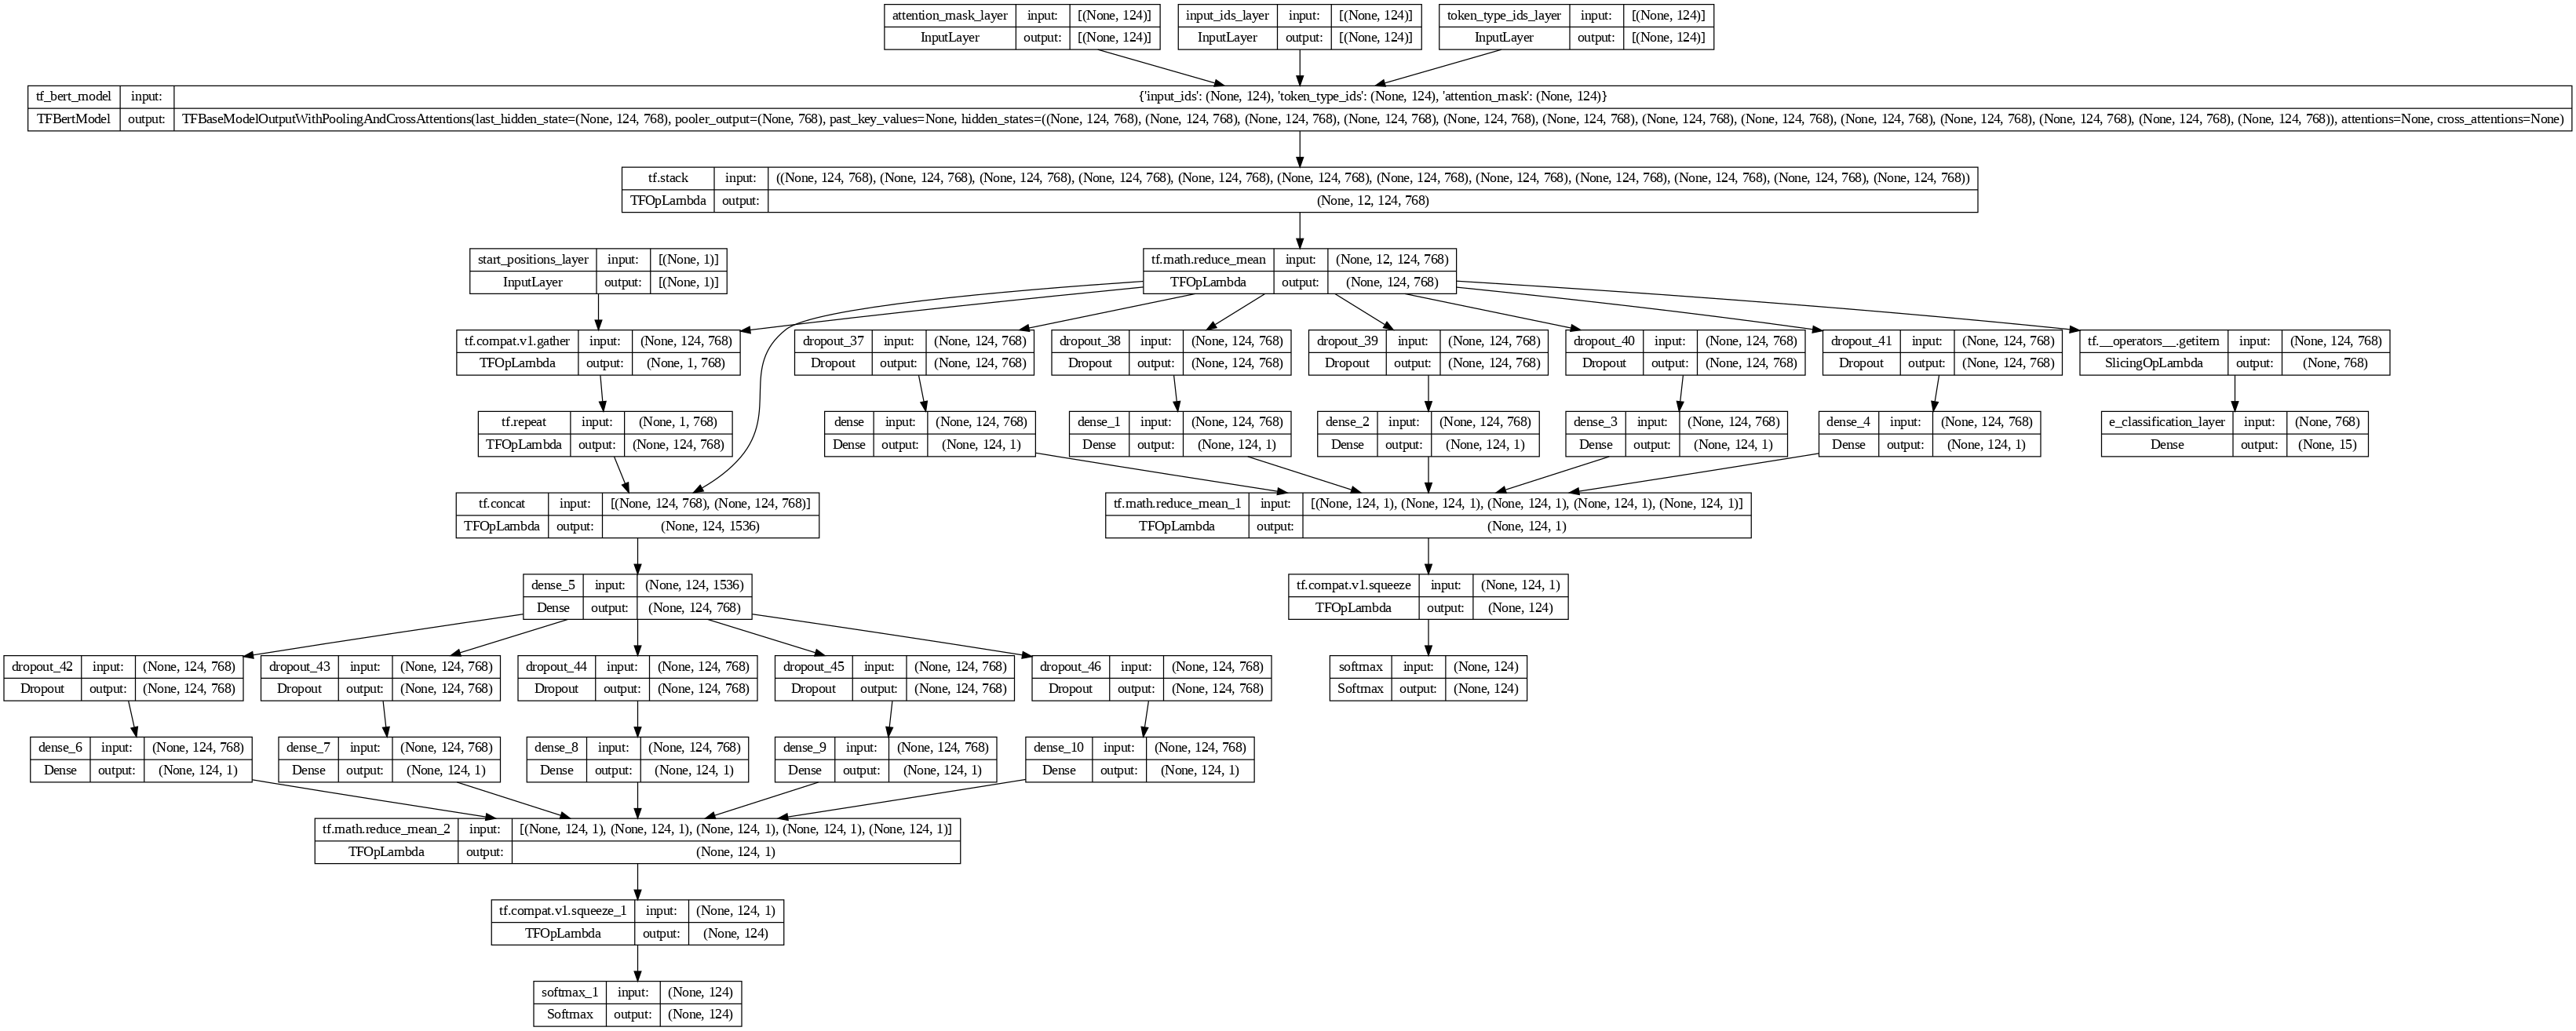

In [ ]:
keras.utils.plot_model(ece_model, show_shapes=True, dpi=90)

## **Supplemental:** Bhat and Modi on Unaugmented RECCON

In [29]:
process_baseline = process_train_data(reccon_train_preprocessed)

ec_train_texts = process_baseline[0]
ec_train_e_labels = process_baseline[1]
ec_train_si_labels = process_baseline[2]
ec_train_ei_labels = process_baseline[3]
ec_train_encodings = process_baseline[4]

In [31]:
ece_model = create_ece_model()

In [32]:
ece_model_history = ece_model.fit([ec_train_encodings.input_ids, ec_train_encodings.token_type_ids, ec_train_encodings.attention_mask, ec_train_si_labels],
                                  [ec_train_e_labels, ec_train_si_labels, ec_train_ei_labels],
                                  batch_size=24,
                                  epochs=1,
                                  )

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


302/302 [==============================] - 527s 2s/step - loss: 0.9877 - e_classification_layer_loss: 0.6673 - softmax_loss: 1.5210 - softmax_1_loss: 1.0952 - e_classification_layer_accuracy: 0.8175 - softmax_accuracy: 0.5127 - softmax_1_accuracy: 0.7275


In [34]:
run_valid_evaluation(ece_model)

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


11/11 [==============================] - 8s 714ms/step
              precision    recall  f1-score   support

       anger     0.5000    0.4706    0.4848        51
     disgust     0.0000    0.0000    0.0000         3
        fear     0.0000    0.0000    0.0000         5
   happiness     0.9474    0.9167    0.9318       216
     sadness     0.8400    0.4884    0.6176        43
    surprise     0.4308    0.9655    0.5957        29

    accuracy                         0.7810       347
   macro avg     0.4530    0.4735    0.4383       347
weighted avg     0.8033    0.7810    0.7776       347



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/o

11/11 [==============================] - 4s 364ms/step
f1_score: 0.7294726822712561


In [35]:
run_test_evaluation(ece_model)

60/60 [==============================] - 18s 304ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/o

              precision    recall  f1-score   support

       anger     0.4711    0.5662    0.5143       302
     disgust     0.0000    0.0000    0.0000        54
        fear     0.0000    0.0000    0.0000        42
   happiness     0.9337    0.9385    0.9361      1155
     sadness     0.7193    0.4162    0.5273       197
    surprise     0.4258    0.7569    0.5450       144

    accuracy                         0.7635      1894
   macro avg     0.4250    0.4463    0.4205      1894
weighted avg     0.7517    0.7635    0.7491      1894

60/60 [==============================] - 18s 306ms/step
f1_score: 0.7452522904752451


### **Brief Sanity Check:** Does Model Output Spans that are Better than Simply Just Taking the Whole Sentence?

In [38]:
end_of_sit = [np.argmax(i == 0) - 1 for i in ec_valid_encodings.input_ids]
for i in range(len(end_of_sit)):
  if end_of_sit[i] == -1:
    end_of_sit[i] = 123
zeros = list(np.zeros(len(end_of_sit)))
zeros = [int(i) for i in zeros]

In [39]:
compute_f1_score(zeros, end_of_sit, ec_valid_si_labels, ec_valid_ei_labels)

0.42911490715192235

In [36]:
end_of_sit = [np.argmax(i == 0) - 1 for i in ec_test_encodings.input_ids]
for i in range(len(end_of_sit)):
  if end_of_sit[i] == -1:
    end_of_sit[i] = 123
zeros = list(np.zeros(len(end_of_sit)))
zeros = [int(i) for i in zeros]

In [37]:
compute_f1_score(zeros, end_of_sit, ec_test_si_labels, ec_test_ei_labels)

0.4515512616482959

## **Post-Analysis:** Looking at Spans and Confusions of Model Run

In [40]:
model_test_run = run_samp_evaluation(ece_model, ec_test_encodings, ec_test_si_labels, ec_test_ei_labels)

60/60 [==============================] - 18s 303ms/step


In [41]:
import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint

In [42]:
# Store predicted test labels from last run of ece_model2 for future use.
model_test_run[0]

<tf.Tensor: shape=(1894,), dtype=int64, numpy=array([3, 5, 3, ..., 3, 3, 3])>

In [43]:
cm = pd.crosstab(ec_test_e_labels, model_test_run[0],
                 rownames=['Actual'], colnames=['Predicted'])

In [49]:
cm[1] = 0
cm[2] = 0
cm = cm[range(6)]
cm

Predicted,0,1,2,3,4,5
Actual,,,,,,
0,171,0,0,42,11,78
1,30,0,0,3,15,6
2,31,0,0,2,3,6
3,20,0,0,1084,2,49
4,94,0,0,13,82,8
5,17,0,0,17,1,109


Text(220.72222222222223, 0.5, 'True')

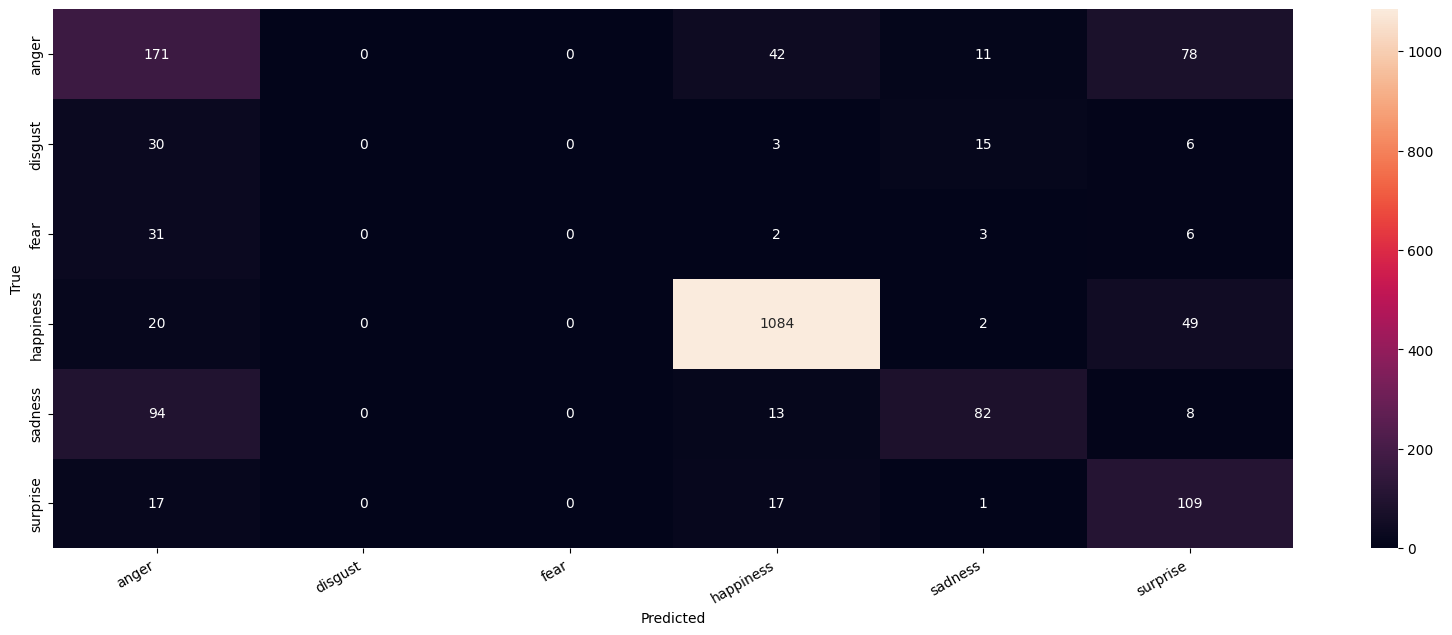

In [50]:
plt.figure(figsize=(20,7))
sns.heatmap(
    cm, annot=True, fmt='g',
    xticklabels=target_names,
    yticklabels=target_names)
plt.xlabel("Predicted")
plt.xticks(rotation=30, ha='right')
plt.ylabel("True")

### **Look at Spans:** Are They Reasonable?

In [56]:
# Get span prediction of i-th test example, checking to see whether spans are reasonable.
def get_span_prediction(i):
  return spanbert_tokenizer.convert_ids_to_tokens(spanbert_tokenizer(reccon_test_preprocessed.input_text[i]).input_ids[model_test_run[1][i]:model_test_run[2][i]+1])

In [57]:
for i in range(10):
  print(get_span_prediction(i))

['We', 'hope', 'you', "'", 're', 'having', 'a', 'good', 'night', '!']
['I', 'just', 'knew', 'we', "'", 'd', 'win', '!']
['We', 'hope', 'you', "'", 're', 'having', 'a', 'good', 'night', '!']
['The', 'night', 'is', 'young', ',', 'folks', '.', 'Get', 'some', 'food', 'and', 'min', '##gle', 'with', 'those', 'faces', 'from', 'yesterday', '.']
['Why', 'don', "'", 't', 'you', 'watch', 'where', 'you', "'", 're', 'going', '?']
['You', "'", 're', 'the', 'one', 'who', 'pulled', 'out', 'in', 'front', 'of', 'me', '!']
['There', 'was', 'plenty', 'of', 'room', 'for', 'me', 'to', 'pull', 'out', '.', 'You', 'didn', "'", 't', 'have', 'to', 'stay', 'in', 'the', 'lane', 'you', 'were', 'in', '.']
['I', 'had', 'every', 'right', 'to', 'stay', 'in', 'the', 'lane', 'I', 'was', 'in', '.']
['You', 'should', 'drive', 'me', 'there', '.']
['It', "'", 's', 'better', 'if', 'we', 'make', 'a', 'police', 'report', 'first', '.', 'Then', 'you', 'can', 'go', 'to', 'the', 'hospital', '.']


In [53]:
reccon_test_preprocessed.head(10)

,Unnamed: 0,id,emotion,utterance,cause_utterance,cause_span,input_text,start_index,end_index,emotion_label
0,7618,dailydialog_te_354_utt_2_true_cause_utt_2_span_0,happiness,"Hi there , everyone . We hope you're having a ...","Hi there , everyone . We hope you're having a ...",We hope you're having a good night !,"Hi there , everyone . We hope you're having a ...",21,30,3
1,7619,dailydialog_te_354_utt_3_true_cause_utt_3_span_0,happiness,Wasn't that football game great ! I just knew ...,Wasn't that football game great ! I just knew ...,Wasn't that football game great ! I just knew ...,Wasn't that football game great ! I just knew ...,17,32,3
2,7620,dailydialog_te_354_utt_4_true_cause_utt_2_span_0,happiness,"The night is young , folks . Get some food and...","Hi there , everyone . We hope you're having a ...",We hope you're having a good night !,"The night is young , folks . Get some food and...",25,34,3
3,7621,dailydialog_te_354_utt_4_true_cause_utt_4_span_1,happiness,"The night is young , folks . Get some food and...","The night is young , folks . Get some food and...","The night is young , folks . Get some food and...","The night is young , folks . Get some food and...",20,38,3
4,7622,dailydialog_tr_9686_utt_2_true_cause_utt_1_span_0,surprise,Me ? You're the one who pulled out in front of...,Why don't you watch where you're going ?,Why don't you watch where you're going ?,Me ? You're the one who pulled out in front of...,16,27,5
5,7623,dailydialog_tr_9686_utt_2_true_cause_utt_2_span_1,surprise,Me ? You're the one who pulled out in front of...,Me ? You're the one who pulled out in front of...,You're the one who pulled out in front of me !,Me ? You're the one who pulled out in front of...,18,30,5
6,7624,dailydialog_tr_9686_utt_4_true_cause_utt_3_span_0,anger,"Hey , listen . I had every right to stay in th...",There was plenty of room for me to pull out . ...,There was plenty of room for me to pull out . ...,"Hey , listen . I had every right to stay in th...",65,89,0
7,7625,dailydialog_tr_9686_utt_4_true_cause_utt_4_span_1,anger,"Hey , listen . I had every right to stay in th...","Hey , listen . I had every right to stay in th...",I had every right to stay in the lane I was in...,"Hey , listen . I had every right to stay in th...",69,93,0
8,7626,dailydialog_tr_9686_utt_12_true_cause_utt_11_s...,surprise,"Oh , yeah ? It's better if we make a police re...",It doesn't work . It looks like it's broken . ...,It looks like it's broken . I need to get to a...,"Oh , yeah ? It's better if we make a police re...",31,52,5
9,7627,dailydialog_tr_9686_utt_13_true_cause_utt_12_s...,anger,Damn it ! I'm injured here . We could wait all...,"Oh , yeah ? It's better if we make a police re...",It's better if we make a police report first ....,Damn it ! I'm injured here . We could wait all...,23,42,0
